# **Independent Component Analysis (ICA) & Sequential Feature Selection (SFS)**

> ### Mitul Agrawal

Drive Link : [PRML Lab 8 Drive](https://drive.google.com/drive/folders/1MKIhdD8NDy6NLCHaTM9FOGi5NR8ikOt-?usp=sharing)

In [ ]:
path = '/content/drive/My Drive/PRML/Lab 8/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Independent Component Analysis (ICA)

###1) Reading, Visualizing and Listening the Audio Files

In [ ]:
from scipy import linalg
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import IPython
import wave

mix_1_wave = wave.open(path+'signal_1.wav','r')
mix_2_wave = wave.open(path+'signal_2.wav','r')
mix_3_wave = wave.open(path+'signal_3.wav','r')

fr = mix_1_wave.getframerate()

signal_1_raw = mix_1_wave.readframes(-1)
signal_1 = np.fromstring(signal_1_raw, 'int16')

signal_2_raw = mix_2_wave.readframes(-1)
signal_2 = np.fromstring(signal_2_raw, 'int16')

signal_3_raw = mix_3_wave.readframes(-1)
signal_3 = np.fromstring(signal_3_raw, 'int16')

In [ ]:
def plot_signal(x,fr,sig=-1,title=None,show=None,alpha=1) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x,alpha=alpha)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

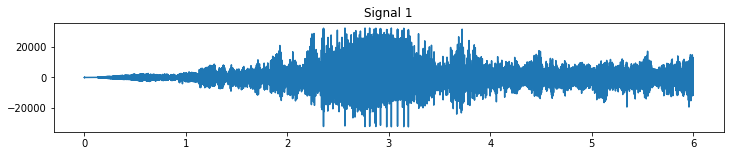

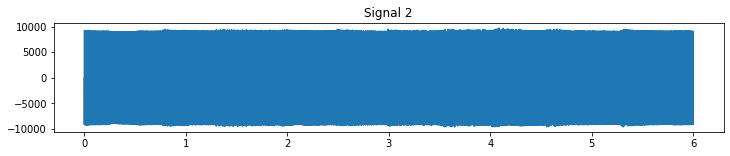

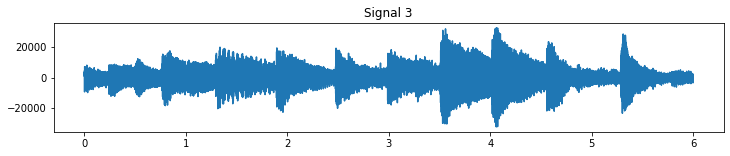

In [ ]:
plot_signal(signal_1,fr,title="Signal 1")
plot_signal(signal_2,fr,title="Signal 2")
plot_signal(signal_3,fr,title="Signal 3")

In [ ]:
#Listen
IPython.display.Audio(path+'signal_1.wav')

In [ ]:
IPython.display.Audio(path+'signal_2.wav')

In [ ]:
IPython.display.Audio(path+'signal_3.wav')

###2) Mixing Signals 

In [ ]:
# X = list([list(signal) for signal in zip(signal_1, signal_2, signal_3)])

mix = [[1.6,-0.5,0.8],
       [0.31,-1.33,0.73],
       [-0.5,0.43,1.21]]

x1 = signal_1 * mix[0][0] + signal_2*mix[0][1] + signal_3*mix[0][2]
x2 = signal_1 * mix[1][0] + signal_2*mix[1][1] + signal_3*mix[1][2]
x3 = signal_1 * mix[2][0] + signal_2*mix[2][1] + signal_3*mix[2][2]

X = np.stack((x1,x2,x3),axis=0)
X.shape

(3, 264515)

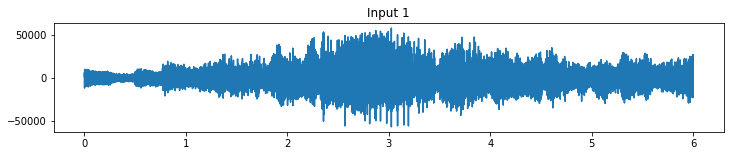

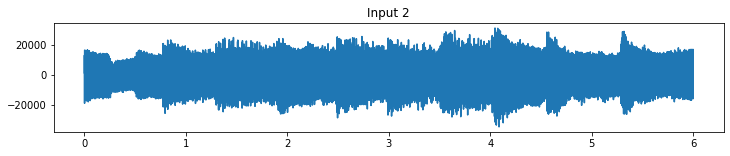

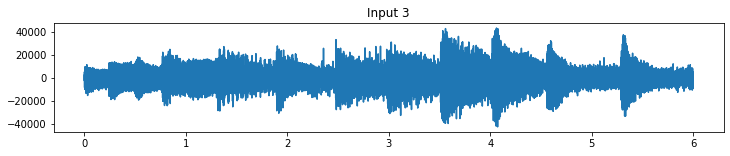

In [ ]:
plot_signal(X,fr,0,title="Input 1")
plot_signal(X,fr,1,title="Input 2")
plot_signal(X,fr,2,title="Input 3")

In [ ]:
import scipy.io.wavfile as wavf

X = X.astype(np.int16)

wavf.write(path+'X0.wav',fr,X[0])
wavf.write(path+'X1.wav',fr,X[1])
wavf.write(path+'X2.wav',fr,X[2])

In [ ]:
IPython.display.Audio(path+'X0.wav')

In [ ]:
IPython.display.Audio(path+'X1.wav')

In [ ]:
IPython.display.Audio(path+'X2.wav')

###3) ICA from Scratch

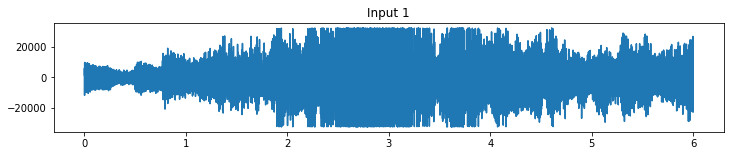

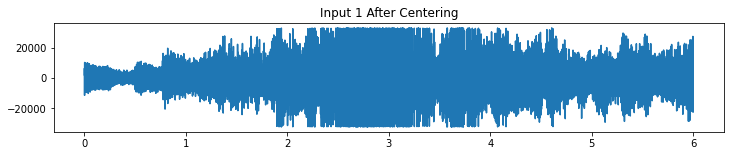

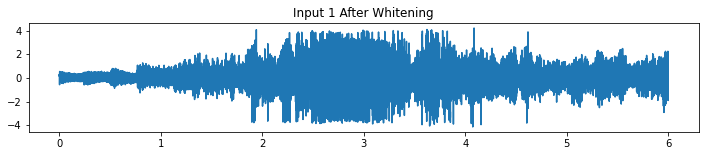

[[-0.36754152 -0.00139958 -0.93000606]
 [-0.34488993 -0.92848798  0.13769896]
 [-0.86369218  0.3713598   0.34077518]]


In [ ]:
# def Center(X) : 
#   n = len(X)
#   c = len(X[0])
#   mean = [sum([x[i] for x in X]) for i in range(c)]
#   mean = [mn/n for mn in mean]
#   for i in range(n) : 
#     X[i] = [X[i][j]-mean[j] for j in range(c)]

import random

class ICA : 

  def __init__(self) : 
    self.W = None

  def Center(self,X) : 
    mean = X.mean(axis=1,keepdims=True)
    X = X - mean
    return X 

  def Whiten(self,X):
      cov = np.cov(X)
      d, E = np.linalg.eigh(cov)
      D = np.diag(d)
      D_inv = np.sqrt(np.linalg.inv(D))
      X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))
      return X_whiten

  def TanH(self,values) :
    for i in range(values.shape[0]) :
      x = np.exp(2*values[i])
      values[i] = (x-1)/(x+1)
    return values

  def d_TanH(self,values) :
    for i in range(values.shape[0]) : 
      e = np.exp(2*values[i])
      values[i] = (4*e)/((e+1)**2)
    return values

  def dot(self,l1,l2) : 
    return sum([l1[i]*l2[i] for i in range(l1.shape[0])]) 

  def find_W(self,X,itr_max=1000,th1=0.999,th2=1.001) : 
    n = X.shape[0]
    W = np.ones((n,n))
    for i in range(n) : 
      w = np.zeros((n))
      for j in range(n) : w[j] = random.uniform(0,1)
      for j in range(itr_max) : 
        w = (X*self.TanH(np.dot(w,X))).mean(axis=1) - w*self.d_TanH(np.dot(w,X)).mean()
        for k in range(i) : 
          w = w - self.dot(w.T,W[k])*W[k]  
        w_m = np.sum((np.square(w)))
        w_m = np.sqrt(w_m)
        w = w/w_m
        wo = self.dot(w,w)
        if(wo>th1 and wo<th2) : break
      W[i] = w
    return W

  def get_Y(self,X) : 
    Xt = np.copy(X)
    plot_signal(Xt,fr,0,title="Input 1")
    Xt = self.Center(Xt)
    plot_signal(Xt,fr,0,title="Input 1 After Centering")
    m1 = np.max(Xt)
    #m1 = 10000
    Xt = self.Whiten(Xt)
    m2 = np.max(Xt)
    #m2 = 1
    #Xt = Xt/10000
    plot_signal(Xt.tolist(),fr,0,title="Input 1 After Whitening")
    W = self.find_W(Xt)
    print(W)
    Xt = Xt*(m1/m2)
    Y = np.dot(W,Xt)
    #plot_signal(Y,fr,0)
    #print(Y.shape)
    return Y

ica = ICA()

S = ica.get_Y(X)

In [ ]:
import scipy.io.wavfile as wavf

S = S.astype(np.int16)

wavf.write(path+'S0.wav',fr,S[0])
wavf.write(path+'S1.wav',fr,S[1])
wavf.write(path+'S2.wav',fr,S[2])

In [ ]:
IPython.display.Audio(path+'S0.wav')

In [ ]:
IPython.display.Audio(path+'S1.wav')

In [ ]:
IPython.display.Audio(path+'S2.wav')

###4) Plotting Signals

Real Source -


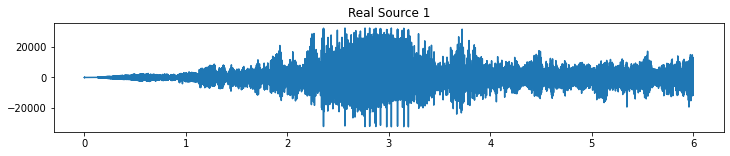

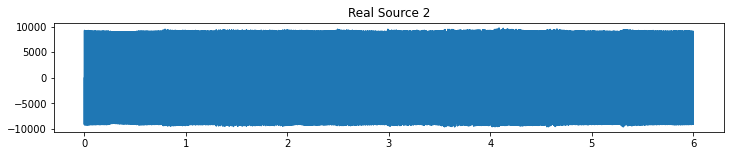

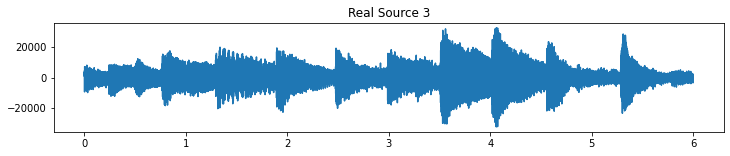

In [ ]:
print("Real Source -")
plot_signal(signal_1,fr,title="Real Source 1")
plot_signal(signal_2,fr,title="Real Source 2")
plot_signal(signal_3,fr,title="Real Source 3")

Mixture -


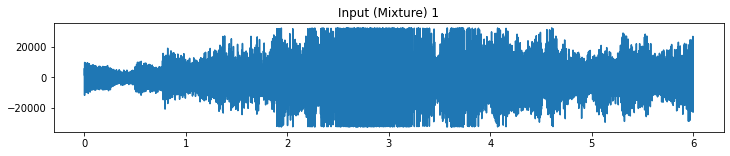

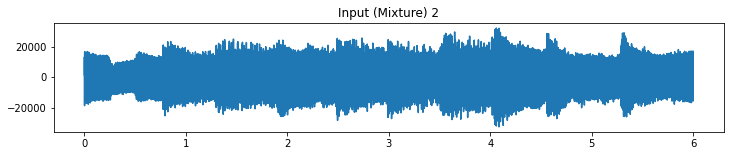

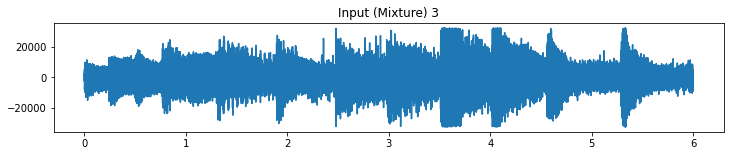

In [ ]:
print("Mixture -")
plot_signal(X,fr,0,title="Input (Mixture) 1")
plot_signal(X,fr,1,title="Input (Mixture) 2")
plot_signal(X,fr,2,title="Input (Mixture) 3")

Predicted Source -


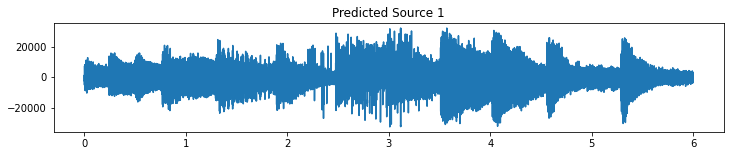

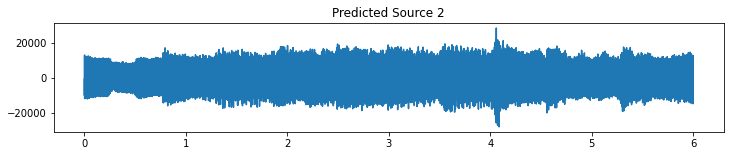

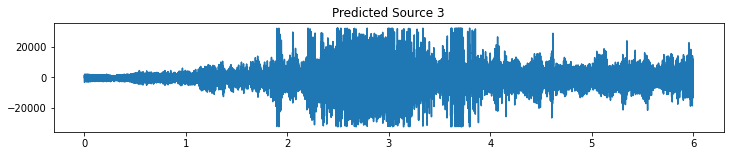

In [ ]:
print("Predicted Source -")
plot_signal(S,fr,0,title="Predicted Source 1")
plot_signal(S,fr,1,title="Predicted Source 2")
plot_signal(S,fr,2,title="Predicted Source 3")

Real vs Predicted Source -


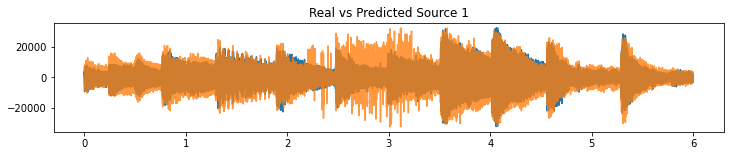

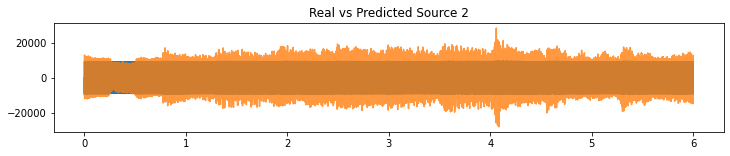

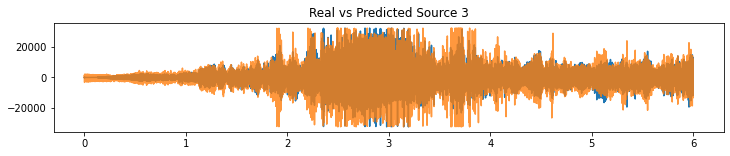

In [ ]:
print("Real vs Predicted Source -")
plot_signal(signal_3,fr,show=False)
plot_signal(S,fr,0,show=True,alpha=0.8,title="Real vs Predicted Source 1")
plot_signal(signal_2,fr,show=False)
plot_signal(S,fr,1,show=True,alpha=0.8,title="Real vs Predicted Source 2")
plot_signal(signal_1,fr,show=False)
plot_signal(S,fr,2,show=True,alpha=0.8,title="Real vs Predicted Source 3")

###5) FastICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=3,random_state=42)
Y = ica.fit_transform(X.T)
Y = Y.T

###6) Separating, Visualizing, Listening to Componenets

Predicted Source -


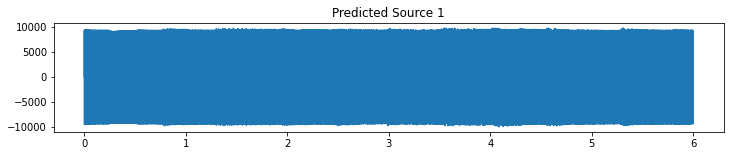

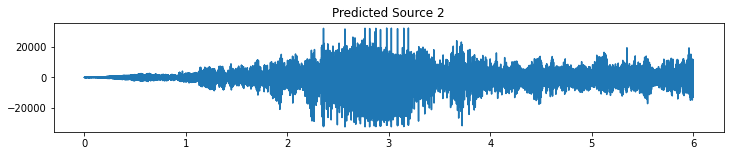

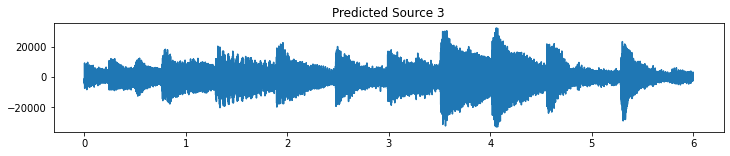

In [ ]:
S1 = Y[0] * (signal_2.max()/Y[0].max())
S2 = Y[1] * (signal_1.max()/Y[1].max())
S3 = Y[2] * (signal_3.max()/Y[2].max())

print("Predicted Source -")
plot_signal(S1,fr,title="Predicted Source 1")
plot_signal(S2,fr,title="Predicted Source 2")
plot_signal(S3,fr,title="Predicted Source 3")

Real vs Predicted Source -


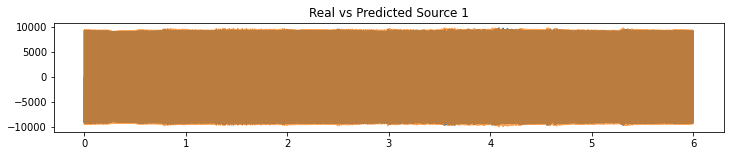

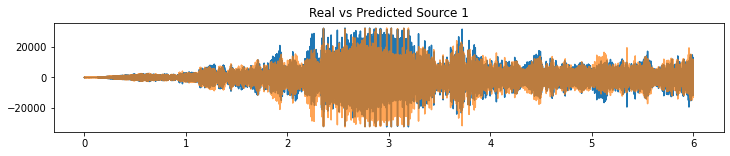

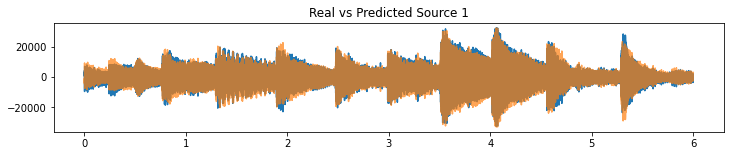

In [ ]:
print("Real vs Predicted Source -")
plot_signal(signal_2,fr,show=False)
plot_signal(S1,fr,show=True,alpha=0.7,title="Real vs Predicted Source 1")
plot_signal(signal_1,fr,show=False)
plot_signal(S2,fr,show=True,alpha=0.7,title="Real vs Predicted Source 1")
plot_signal(signal_3,fr,show=False)
plot_signal(S3,fr,show=True,alpha=0.7,title="Real vs Predicted Source 1")

In [ ]:
import scipy.io.wavfile as wavf

wavf.write(path+'S0.wav',fr,S1.astype(np.int16))
wavf.write(path+'S1.wav',fr,S2.astype(np.int16))
wavf.write(path+'S2.wav',fr,S3.astype(np.int16))

In [ ]:
IPython.display.Audio(path+'S0.wav')

In [ ]:
IPython.display.Audio(path+'S1.wav')

In [ ]:
IPython.display.Audio(path+'S2.wav')

###7) Scratch ICA vs Inbuilt FastICA 

Scratch ICA vs Inbuilt FastICA -


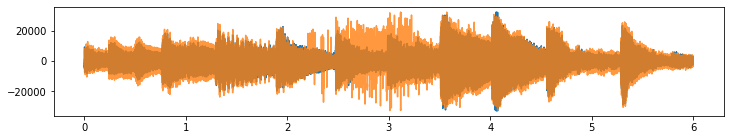

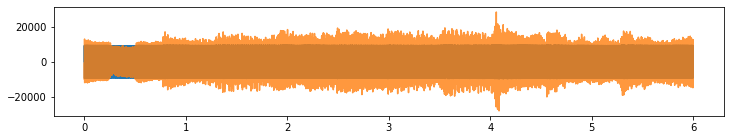

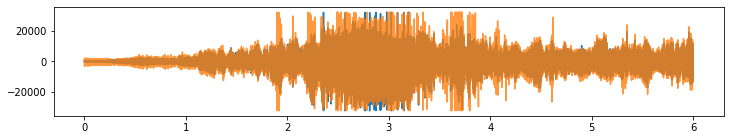

In [ ]:
print("Scratch ICA vs Inbuilt FastICA -")
plot_signal(S3,fr,show=False)
plot_signal(S,fr,0,show=True,alpha=0.8)
plot_signal(S1,fr,show=False)
plot_signal(S,fr,1,show=True,alpha=0.8)
plot_signal(S2,fr,show=False)
plot_signal(S,fr,2,show=True,alpha=0.8)

In [ ]:
''' 
The plots of ICA and FastICA are very Similar

Output of FastICA matched a bit better with Real Source than Scratch ICA

The three source components got separated in both ICA and FastICA but the noise 
in FastICA is a bit less 
''' 

' \nThe plots of ICA and FastICA are very Similar\n\nBut on hearing the three source components did get separated in ICA but in \nFastICA it was as if one component got repeated two times so only two \ncomponenets were retrived from it\n'

##Sequential Feature Selection (SFS)

###1) Preprocessing

####Importing

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import time

df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

df_train.head(4)

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   
2                                  2  ...                       5   
3                                  5  ...                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied  
3                       9.0  neutral or dissatisfied  

[4 rows x 25 columns]

####Cleaning

In [ ]:
def remove_missing(df) : 
  remove = []
  for i, row in df.iterrows():
    if row.isna().values.any() : remove.append(i)
  df.drop(remove,axis=0,inplace=True)

def fill_missing(df) : 
  for col in df : 
    df[col].fillna((df[col].mode()), inplace=True)

def remove_mismatch(df) : 
  for col in df : 
    df.reset_index(drop=True, inplace=True)
    s = [False]*len(df[col])
    for i,cell in enumerate(df[col]) : 
      try : n = int(cell)
      except : s[i] = True
    t = s.count(True)
    f = s.count(False)
    st = False
    if(t>f) : st = True
    remove = [i for i in range(len(df[col])) if s[i]!=st]
    df.drop(remove,axis=0,inplace=True)

def fill_mismatch(df) : 
  for col in df : 
    s = [False]*len(df[col])
    for i,cell in enumerate(df[col]) : 
      try : n = int(cell)
      except : s[i] = True
    t = s.count(True)
    f = s.count(False)
    st = False
    if(t>f) : st = True
    for i in range(len(df[col])) : 
      if(s[i]!=st) : 
        try : 
          df[col][i] = df[col].median()
        except :
          df[col][i] = df[col].mode()

def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

str_to_num(df_train)
str_to_num(df_test)

fill_missing(df_train)
fill_missing(df_test)

fill_mismatch(df_train)
fill_mismatch(df_test)

str_to_num(df_train)
str_to_num(df_test)

df_train.head(4)

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   
2                                  2  ...                       5   
3                                  5  ...                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied  
3                       9.0  neutral or dissatisfied  

[4 rows x 25 columns]

####Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_train['Gender']= label_encoder.fit_transform(df_train['Gender'])
df_test['Gender']= label_encoder.fit_transform(df_test['Gender'])
df_train['Customer Type']= label_encoder.fit_transform(df_train['Customer Type'])
df_test['Customer Type']= label_encoder.fit_transform(df_test['Customer Type'])
df_train['Type of Travel']= label_encoder.fit_transform(df_train['Type of Travel'])
df_test['Type of Travel']= label_encoder.fit_transform(df_test['Type of Travel'])
df_train['Class']= label_encoder.fit_transform(df_train['Class'])
df_test['Class']= label_encoder.fit_transform(df_test['Class'])
df_train['satisfaction']= label_encoder.fit_transform(df_train['satisfaction'])
df_test['satisfaction']= label_encoder.fit_transform(df_test['satisfaction'])
df_train

Unnamed: 0      id  Gender  Customer Type  Age  Type of Travel  Class  \
0                0   70172       1              0   13               1      2   
1                1    5047       1              1   25               0      0   
2                2  110028       0              0   26               0      0   
3                3   24026       0              0   25               0      0   
4                4  119299       1              0   61               0      0   
...            ...     ...     ...            ...  ...             ...    ...   
103899      103899   94171       0              1   23               0      1   
103900      103900   73097       1              0   49               0      0   
103901      103901   68825       1              1   30               0      0   
103902      103902   54173       0              1   22               0      1   
103903      103903   62567       1              0   27               0      0   

        Flight Distance  Inflight wifi service  \
0                   460                      3   
1                   235                      3   
2                  1142                      2   
3                   562                      2   
4                   214                      3   
...                 ...                    ...   
103899              192                      2   
103900             2347                      4   
103901             1995                      1   
103902             1000                      1   
103903             1723                      1   

        Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                       4  ...                       5   
1                                       2  ...                       1   
2                                       2  ...                       5   
3                                       5  ...                       2   
4                                       3  ...                       3   
...                                   ...  ...                     ...   
103899                                  1  ...                       2   
103900                                  4  ...                       5   
103901                                  1  ...                       4   
103902                                  1  ...                       1   
103903                                  3  ...                       1   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                      4                 3                 4                4   
1                      1                 5                 3                1   
2                      4                 3                 4                4   
3                      2                 5                 3                1   
4                      3                 4                 4                3   
...                  ...               ...               ...              ...   
103899                 3                 1                 4                2   
103900                 5                 5                 5                5   
103901                 3                 2                 4                5   
103902                 4                 5                 1                5   
103903                 1                 1                 4                4   

        Inflight service  Cleanliness  Departure Delay in Minutes  \
0                      5            5                          25   
1                      4            1                           1   
2                      4            5                           0   
3                      4            2                          11   
4                      3            3                           0   
...                  ...          ...                         ...   
103899                 3            2                           3   
103900              

####Separating Class from Data

In [ ]:
x_train = df_train.iloc[:,:-1].copy()
y_train = df_train.iloc[:,-1].copy()

x_test = df_test.iloc[:,:-1].copy()
y_test = df_test.iloc[:,-1].copy()

print("Train Data   :",x_train.shape)
print("Train Labels :",y_train.shape)
print()
print("Test Data    :",x_test.shape)
print("Test Labels  :",y_test.shape)

Train Data   : (103904, 24)
Train Labels : (103904,)

Test Data    : (25976, 24)
Test Labels  : (25976,)


###Bonus : SFS from Scratch

Best 10 Features : ['Online boarding', 'Type of Travel', 'Inflight wifi service', 'Gate location', 'Inflight service', 'Customer Type', 'Class', 'Baggage handling', 'Checkin service', 'Arrival Delay in Minutes']



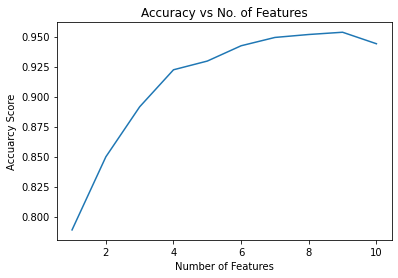

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

features = list(x_train)

best = []
acc_best = []

for i in range(10):

  temp = best.copy()
  max_f = features[0]
  max_r = 0

  for j in features:

    temp.append(j)
    df = df_train.loc[:,temp]
    classes = df_train.loc[:,'satisfaction']
    x_train,x_test,y_train, y_test = train_test_split(df, classes, test_size=0.2, random_state=42)
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(x_train,y_train)
    predictions = clf.predict(x_test)
    acc = accuracy_score(predictions,y_test)
   
    if acc>max_r:
      max_r = acc
      max_f = j
    temp.remove(j)
  
  best.append(max_f)
  acc_best.append(max_r)
  features.remove(max_f)
  
print("Best 10 Features :",best)
print()

plt.plot(list(range(1,11)),acc_best)
plt.xlabel('Number of Features')
plt.ylabel('Accuarcy Score')
plt.title('Accuracy vs No. of Features')
plt.show()

###2) Creating Object of SFS

In [ ]:
import joblib

import sys
sys.modules['sklearn.externals.joblib'] = joblib

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)

model = SFS(estimator= clf, k_features=10,forward=True, floating=False,scoring='accuracy',clone_estimator=False)

###3) Training

In [ ]:
model.fit(x_train, y_train)
cols = list(model.k_feature_idx_)
cols

[3, 5, 6, 8, 11, 13, 14, 15, 18, 20]

###4) SFS, SBS, SFFS, SBFS 

In [ ]:
sfs = SFS(estimator= clf, k_features=10,forward=True, floating=False,scoring='accuracy',clone_estimator=False, cv=4)
sbs = SFS(estimator= clf, k_features=10,forward=False, floating=False,scoring='accuracy',clone_estimator=False, cv=4)
sffs = SFS(estimator= clf, k_features=10,forward=True, floating=True,scoring='accuracy',clone_estimator=False, cv=4)
sbfs = SFS(estimator= clf, k_features=10,forward=False, floating=True,scoring='accuracy',clone_estimator=False, cv=4)

sfs.fit(x_train.values, y_train.values)
sbs.fit(x_train.values, y_train.values)
sffs.fit(x_train.values, y_train.values)
sbfs.fit(x_train.values, y_train.values)

print("SFS  :",sfs.k_score_)
print("SBS  :",sbs.k_score_)
print("SFFS :",sffs.k_score_)
print("SBFS :",sbfs.k_score_)

SFS  : 0.9499441792423776
SBS  : 0.9513396981829381
SFFS : 0.9513396981829381
SBFS : 0.9513396981829381


In [ ]:
print("SFS :")
print('  10 Features    -',sfs.subsets_[10]['feature_names'])
print('  Accuracy Score -',sfs.subsets_[10]['avg_score'])
print('  CV Score       -',sfs.subsets_[10]['cv_scores'])
print()
print("SBS :")
print('  10 Features    -',sbs.subsets_[10]['feature_names'])
print('  Accuracy Score -',sbs.subsets_[10]['avg_score'])
print('  CV Score       -',sbs.subsets_[10]['cv_scores'])
print()
print("SFFS :")
print('  10 Features    -',sffs.subsets_[10]['feature_names'])
print('  Accuracy Score -',sffs.subsets_[10]['avg_score'])
print('  CV Score       -',sffs.subsets_[10]['cv_scores'])
print()
print("SBFS :")
print('  10 Features    -',sbfs.subsets_[10]['feature_names'])
print('  Accuracy Score -',sbfs.subsets_[10]['avg_score'])
print('  CV Score       -',sbfs.subsets_[10]['cv_scores'])

SFS :
  10 Features    - ('3', '5', '6', '8', '11', '13', '14', '15', '18', '20')
  Accuracy Score - 0.9499441792423776
  CV Score       - [0.94906837 0.94960733 0.94968432 0.95141669]

SBS :
  10 Features    - ('3', '5', '6', '8', '13', '14', '15', '18', '20', '21')
  Accuracy Score - 0.9513396981829381
  CV Score       - [0.95110872 0.95080074 0.95068525 0.95276409]

SFFS :
  10 Features    - ('3', '5', '6', '8', '13', '14', '15', '18', '20', '21')
  Accuracy Score - 0.9513396981829381
  CV Score       - [0.95110872 0.95080074 0.95068525 0.95276409]

SBFS :
  10 Features    - ('3', '5', '6', '8', '13', '14', '15', '18', '20', '21')
  Accuracy Score - 0.9513396981829381
  CV Score       - [0.95110872 0.95080074 0.95068525 0.95276409]


###5) Visualizing Output

In [ ]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

feature_idx  \
1                                  (13,)   
2                                (5, 13)   
3                             (5, 8, 13)   
4                         (5, 8, 11, 13)   
5                      (3, 5, 8, 11, 13)   
6                  (3, 5, 8, 11, 13, 18)   
7               (3, 5, 6, 8, 11, 13, 18)   
8           (3, 5, 6, 8, 11, 13, 18, 20)   
9       (3, 5, 6, 8, 11, 13, 14, 18, 20)   
10  (3, 5, 6, 8, 11, 13, 14, 15, 18, 20)   

                                            cv_scores avg_score  \
1   [0.7895364952263628, 0.792231290421928, 0.7930...  0.790383   
2   [0.8483215275639051, 0.8512088081305821, 0.850...  0.849688   
3   [0.8915152448413921, 0.8920157068062827, 0.892...  0.891265   
4   [0.919271635355713, 0.9229673544810595, 0.9223...  0.921735   
5   [0.9277024946104097, 0.9285494302433015, 0.929...    0.9288   
6   [0.9393671080997844, 0.9424468740375731, 0.939...  0.941282   
7   [0.9464120726824762, 0.94876039421004, 0.94852...  0.948279   
8   [0.9496458269171543, 0.9501847859562673, 0.950...  0.950685   
9   [0.9490683708038189, 0.9509162303664922, 0.950...  0.950695   
10  [0.9490683708038189, 0.949607329842932, 0.9496...  0.949944   

                           feature_names  ci_bound   std_dev   std_err  
1                                  (13,)  0.003933  0.002454  0.001417  
2                                (5, 13)  0.001959  0.001222  0.000705  
3                             (5, 8, 13)  0.001961  0.001224  0.000706  
4                         (5, 8, 11, 13)  0.002316  0.001445  0.000834  
5                      (3, 5, 8, 11, 13)  0.001189  0.000742  0.000428  
6                  (3, 5, 8, 11, 13, 18)  0.002875  0.001793  0.001035  
7               (3, 5, 6, 8, 11, 13, 18)  0.001805  0.001126   0.00065  
8           (3, 5, 6, 8, 11, 13, 18, 20)  0.001451  0.000905  0.000522  
9       (3, 5, 6, 8, 11, 13, 14, 18, 20)  0.001717  0.001071  0.000618  
10  (3, 5, 6, 8, 11, 13, 14, 15, 18, 20)  0.001415  0.000883   0.00051

In [ ]:
pd.DataFrame.from_dict(sbs.get_metric_dict()).T

feature_idx  \
24  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
23  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...   
20  (1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...   
19  (1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 1...   
18  (1, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 16, 17, ...   
17  (1, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 17, 18, ...   
16  (1, 3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19,...   
15  (1, 3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19,...   
14  (3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19, 20...   
13   (3, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19, 20, 21)   
12       (3, 5, 6, 8, 11, 13, 14, 15, 18, 19, 20, 21)   
11           (3, 5, 6, 8, 13, 14, 15, 18, 19, 20, 21)   
10               (3, 5, 6, 8, 13, 14, 15, 18, 20, 21)   

                                            cv_scores avg_score  \
24  [0.9243147520788421, 0.9499153064367108, 0.947...  0.939627   
23  [0.9442177394518017, 0.9469895287958116, 0.945...  0.946046   
22  [0.944371727748691, 0.94876039421004, 0.946219...  0.946768   
21  [0.944256236526024, 0.9500307976593779, 0.9462...  0.947278   
20  [0.9445642131198029, 0.9494533415460426, 0.946...  0.947172   
19  [0.9448721897135818, 0.9489528795811518, 0.945...  0.946874   
18  [0.945218663381583, 0.9487218971358177, 0.9443...  0.946768   
17  [0.946835540498922, 0.9471820141669233, 0.9452...  0.947028   
16  [0.9467970434246997, 0.9474129966122574, 0.945...  0.946932   
15  [0.9466430551278103, 0.9480674468740375, 0.944...  0.946508   
14  [0.944795195565137, 0.9466815522020327, 0.9455...  0.945661   
13  [0.9439097628580227, 0.9437557745611334, 0.945...  0.945074   
12  [0.9479134585771481, 0.9477209732060363, 0.945...  0.947702   
11  [0.949299353249153, 0.9502617801047121, 0.9494...  0.950069   
10  [0.9511087157376039, 0.9508007391438251, 0.950...   0.95134   

                                        feature_names  ci_bound   std_dev  \
24  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.016217  0.010117   
23  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.001844   0.00115   
22  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.002649  0.001652   
21  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...  0.003531  0.002203   
20  (1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...  0.002989  0.001865   
19  (1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 1...   0.00254  0.001584   
18  (1, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 16, 17, ...  0.003233  0.002017   
17  (1, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 17, 18, ...  0.001995  0.001245   
16  (1, 3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19,...  0.001059   0.00066   
15  (1, 3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19,...  0.002038  0.001271   
14  (3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19, 20...  0.001078  0.000673   
13   (3, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19, 20, 21)  0.002348  0.001465   
12       (3, 5, 6, 8, 11, 13, 14, 15, 18, 19, 20, 21)  0.002084    0.0013   
11           (3, 5, 6, 8, 13, 14, 15, 18, 19, 20, 21)   0.00125   0.00078   
10               (3, 5, 6, 8, 13, 14, 15, 18, 20, 21)  0.001341  0.000837   

     std_err  
24  0.005841  
23  0.000664  
22  0.000954  
21  0.001272  
20  0.001077  
19  0.000915  
18  0.001164  
17  0.000719  
16  0.000381  
15  0.000734  
14  0.000388  
13  0.000846  
12  0.000751  
11   0.00045  
10  0.000483

In [ ]:
pd.DataFrame.from_dict(sffs.get_metric_dict()).T

feature_idx  \
1                                  (13,)   
2                                (5, 13)   
3                             (5, 8, 13)   
4                         (5, 8, 11, 13)   
5                      (3, 5, 8, 11, 13)   
6                  (3, 5, 8, 11, 13, 18)   
7               (3, 5, 6, 8, 11, 13, 18)   
8           (3, 5, 6, 8, 11, 13, 18, 20)   
9       (3, 5, 6, 8, 13, 14, 15, 18, 20)   
10  (3, 5, 6, 8, 13, 14, 15, 18, 20, 21)   

                                            cv_scores avg_score  \
1   [0.7895364952263628, 0.792231290421928, 0.7930...  0.790383   
2   [0.8483215275639051, 0.8512088081305821, 0.850...  0.849688   
3   [0.8915152448413921, 0.8920157068062827, 0.892...  0.891265   
4   [0.919271635355713, 0.9229673544810595, 0.9223...  0.921735   
5   [0.9277024946104097, 0.9285494302433015, 0.929...    0.9288   
6   [0.9393671080997844, 0.9424468740375731, 0.939...  0.941282   
7   [0.9464120726824762, 0.94876039421004, 0.94852...  0.948279   
8   [0.9496458269171543, 0.9501847859562673, 0.950...  0.950685   
9   [0.9504157684016015, 0.9506082537727133, 0.950...  0.950878   
10  [0.9511087157376039, 0.9508007391438251, 0.950...   0.95134   

                           feature_names  ci_bound   std_dev   std_err  
1                                  (13,)  0.003933  0.002454  0.001417  
2                                (5, 13)  0.001959  0.001222  0.000705  
3                             (5, 8, 13)  0.001961  0.001224  0.000706  
4                         (5, 8, 11, 13)  0.002316  0.001445  0.000834  
5                      (3, 5, 8, 11, 13)  0.001189  0.000742  0.000428  
6                  (3, 5, 8, 11, 13, 18)  0.002875  0.001793  0.001035  
7               (3, 5, 6, 8, 11, 13, 18)  0.001805  0.001126   0.00065  
8           (3, 5, 6, 8, 11, 13, 18, 20)  0.001451  0.000905  0.000522  
9       (3, 5, 6, 8, 13, 14, 15, 18, 20)  0.001498  0.000935   0.00054  
10  (3, 5, 6, 8, 13, 14, 15, 18, 20, 21)  0.001341  0.000837  0.000483

In [ ]:
pd.DataFrame.from_dict(sbfs.get_metric_dict()).T

feature_idx  \
24  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
23  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...   
20  (1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...   
19  (1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, ...   
18  (1, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 16, 17, ...   
17  (1, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 17, 18, ...   
16  (1, 3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19,...   
15  (1, 3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19,...   
14  (3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19, 20...   
13   (3, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19, 20, 21)   
12       (3, 5, 6, 8, 11, 13, 14, 15, 18, 19, 20, 21)   
11           (3, 5, 6, 8, 13, 14, 15, 18, 19, 20, 21)   
10               (3, 5, 6, 8, 13, 14, 15, 18, 20, 21)   

                                            cv_scores avg_score  \
24  [0.9243147520788421, 0.9499153064367108, 0.947...  0.939627   
23  [0.9442177394518017, 0.9469895287958116, 0.945...  0.946046   
22  [0.944371727748691, 0.94876039421004, 0.946219...  0.946768   
21  [0.944256236526024, 0.9500307976593779, 0.9462...  0.947278   
20  [0.9445642131198029, 0.9494533415460426, 0.946...  0.947172   
19  [0.9458731136433631, 0.9494533415460426, 0.944...   0.94698   
18  [0.945218663381583, 0.9487218971358177, 0.9443...  0.946768   
17  [0.946835540498922, 0.9471820141669233, 0.9452...  0.947028   
16  [0.9467970434246997, 0.9474129966122574, 0.945...  0.946932   
15  [0.9466430551278103, 0.9480674468740375, 0.944...  0.946508   
14  [0.944795195565137, 0.9466815522020327, 0.9455...  0.945661   
13  [0.9439097628580227, 0.9437557745611334, 0.945...  0.945074   
12  [0.9479134585771481, 0.9477209732060363, 0.945...  0.947702   
11  [0.949299353249153, 0.9502617801047121, 0.9494...  0.950069   
10  [0.9511087157376039, 0.9508007391438251, 0.950...   0.95134   

                                        feature_names  ci_bound   std_dev  \
24  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.016217  0.010117   
23  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.001844   0.00115   
22  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.002649  0.001652   
21  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...  0.003531  0.002203   
20  (1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...  0.002989  0.001865   
19  (1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, ...   0.00279  0.001741   
18  (1, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 16, 17, ...  0.003233  0.002017   
17  (1, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 17, 18, ...  0.001995  0.001245   
16  (1, 3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19,...  0.001059   0.00066   
15  (1, 3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19,...  0.002038  0.001271   
14  (3, 4, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19, 20...  0.001078  0.000673   
13   (3, 5, 6, 8, 11, 13, 14, 15, 17, 18, 19, 20, 21)  0.002348  0.001465   
12       (3, 5, 6, 8, 11, 13, 14, 15, 18, 19, 20, 21)  0.002084    0.0013   
11           (3, 5, 6, 8, 13, 14, 15, 18, 19, 20, 21)   0.00125   0.00078   
10               (3, 5, 6, 8, 13, 14, 15, 18, 20, 21)  0.001341  0.000837   

     std_err  
24  0.005841  
23  0.000664  
22  0.000954  
21  0.001272  
20  0.001077  
19  0.001005  
18  0.001164  
17  0.000719  
16  0.000381  
15  0.000734  
14  0.000388  
13  0.000846  
12  0.000751  
11   0.00045  
10  0.000483

###6) Plotting Configuration Results

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

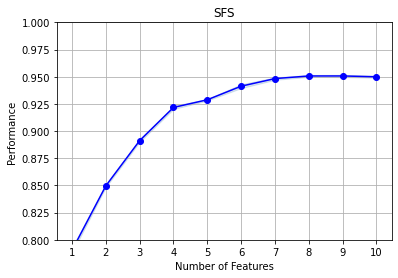

In [ ]:
plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('SFS')
plt.show()

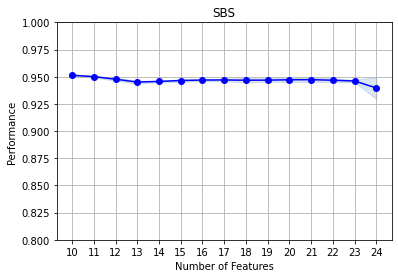

In [ ]:
plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('SBS')
plt.show()

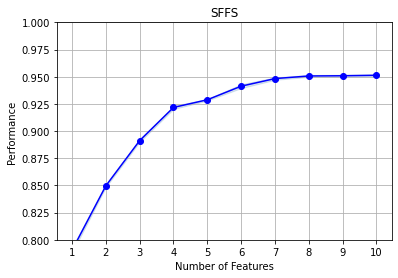

In [ ]:
plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('SFFS')
plt.show()

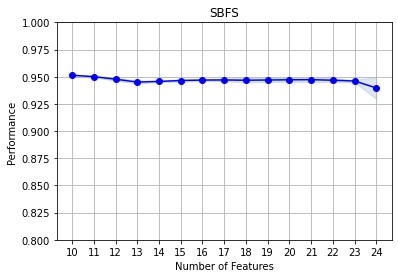

In [ ]:
plot_sfs(sbfs.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('SBFS')
plt.show()

###7) Varying Features

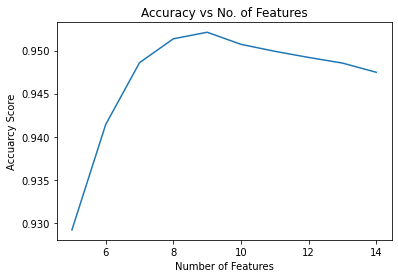

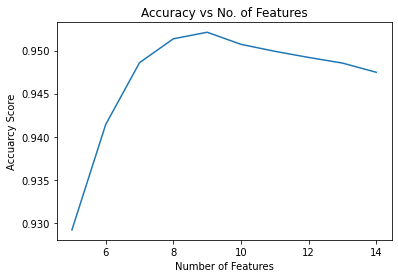

In [ ]:
features = []
acc = []
for i in range(5,15):
  model = SFS(estimator= clf,k_features=i,forward=True,floating=False,scoring='accuracy',clone_estimator=False)
  model.fit(x_train,y_train)
  features.append(i)
  acc.append(model.subsets_[i]['avg_score'])

plt.plot(features,acc)
plt.xlabel('Number of Features')
plt.ylabel('Accuarcy Score')
plt.title('Accuracy vs No. of Features')
plt.show()